<a href="https://colab.research.google.com/github/hflautert/AnomalyDetection/blob/main/IOTIN_TCPSYN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Experimento de reconhecimento de anomalias em ataque DoS do tipo TCPSYN.

Fonte de dados: https://ieee-dataport.org/open-access/iot-network-intrusion-dataset

Hyunjae Kang, Dong Hyun Ahn, Gyung Min Lee, Jeong Do Yoo, Kyung Ho Park, Huy Kang Kim, September 27, 2019, "IoT network intrusion dataset", IEEE Dataport, doi: https://dx.doi.org/10.21227/q70p-q449.


Para gerar as estatísticas, os arquivos foram abertos com WireShark, aplicado filtro `tcp.flags.syn == 1 and tcp.flags.ack == 0`. Posteriormente gerado dados no menu Statistics, I/O Graph, salvo como csv, nos intervalos de 100ms, 500ms e 1 segundo.

In [2]:
# Importando bibliotecas
# Manipulação de matrizes e operações matemáticas de alto nível
import numpy as np
# Geração de gráficos
import matplotlib.pyplot as plt

In [123]:
def prep_csv(arquivocsv):
  array_np = np.loadtxt(arquivocsv, delimiter=',',skiprows=1)
  array_np = array_np[:, 1]
  return array_np

def visualiza(serie_dados,u_tempo,c,titulo,tipo):
  plt.plot(serie_dados, color = c )
  plt.title('Número de pacotes '+tipo+' '+titulo)
  plt.xlabel('Intervalo de tempo')
  plt.ylabel('pacotes '+tipo+' / '+u_tempo)
  plt.show()

def visualizamix(serie_dados_a,ca,serie_dados_n,cn,u_tempo,tipo):
  plt.plot(serie_dados_a, color = ca, label = 'Sob ataque')
  plt.plot(serie_dados_n, color = cn, label = 'Em condições normais')
  plt.title('Número de pacotes '+tipo+' em rede IoT')
  plt.xlabel('Intervalo de tempo')
  plt.ylabel('pacotes '+tipo+' / '+u_tempo)
  plt.legend(loc='best')
  plt.show()

#
# Funcao para testar o modelo
#
# serie_normal = array de pacotes em qualquer intervalo de tempo do tráfego de rede normal
# serie_ataque = array de pacotes em qualquer intervalo de tempo do tráfego de rede com ataques
# delta_v = variação da media móvel para reconhecer como anomalia ou ataque - quanto menor mais sensível
# inter_mm = intervalo de dados para obter a media móvel - quanto menor mais sensível
# taxa_min = taxa mínima (de pacotes em relacao ao tempo) para considerar a variação, abaixo disso não será avaliado - quanto menor mais sensível
#
def aplica_modelo(serie_normal,serie_ataque,delta_v,inter_mm,taxa_min):
  # Organiza o array em varias linhas (matriz), cada linha conterá a serie de dados para calcular a média móvel
  matriz_normal = np.lib.stride_tricks.sliding_window_view(serie_normal,inter_mm)
  matriz_ataque = np.lib.stride_tricks.sliding_window_view(serie_ataque,inter_mm)

  # Contadores
  cont_ataque = 0 #ataques
  cont_f_ataque = 0 #fasos positivos
  sob_ataque = 0 # caso seja um ataque de crescimento longo, será contabilizado apenas como um ataque

  # Inicia calculo e comparacao das medias moveis
  for i in range(len(matriz_ataque)):
    if i<2:
      pass #sem base para comparacao
    else:
      antpen_media=matriz_ataque[i-2].mean()
      pen_media=matriz_ataque[i-1].mean()
      media_atual=matriz_ataque[i].mean()
      #print('media_atual:',media_atual)
      if (antpen_media<taxa_min) and (pen_media<taxa_min) and (media_atual<taxa_min):
        pass # taxa mínima
      else:
        if (media_atual>pen_media*delta_v) and (pen_media>antpen_media*delta_v) and sob_ataque == 0:
          # Se a media atual é delta_v maior que a média anterior, e a média anterior é delta_v maior que a antepenúltima, contabiliza ataque
          cont_ataque += 1
          sob_ataque = 1
        if (antpen_media>pen_media) and (pen_media>media_atual):
          sob_ataque = 0 # Media em queda, desarma sob ataque - para contabilizar novos ataques
  # Desarma flag para avaliar o tráfego de rede normal
  sob_ataque = 0
  for i in range(len(matriz_normal)):
    if i<2:
      pass #sem base para comparacao
    else:
      antpen_media=matriz_normal[i-2].mean()
      pen_media=matriz_normal[i-1].mean()
      media_atual=matriz_normal[i].mean()
      if (antpen_media<taxa_min) and (pen_media<taxa_min) and (media_atual<taxa_min):
        pass # taxa mínima
      else:
        if (media_atual>pen_media*delta_v) and (pen_media>antpen_media*delta_v) and sob_ataque == 0:
          # Se a media atual é delta_v maior que a média anterior, e a média anterior é delta_v maior que a antepenúltima, contabiliza ataque
          cont_f_ataque += 1
          sob_ataque = 1
        if (antpen_media>pen_media) and (pen_media>media_atual):
          sob_ataque = 0 # Media em queda, desarma sob ataque - para contabilizar novos ataques

  return cont_ataque,cont_f_ataque


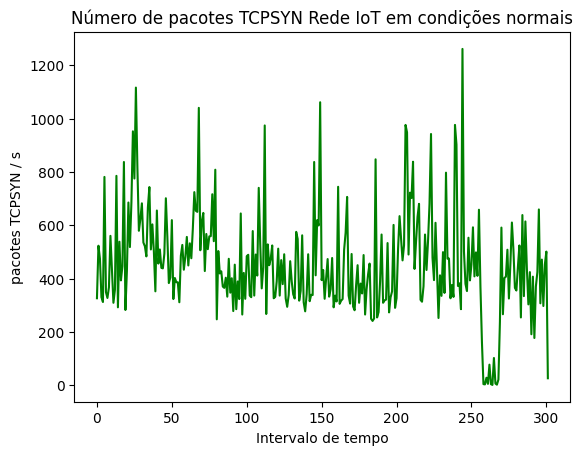

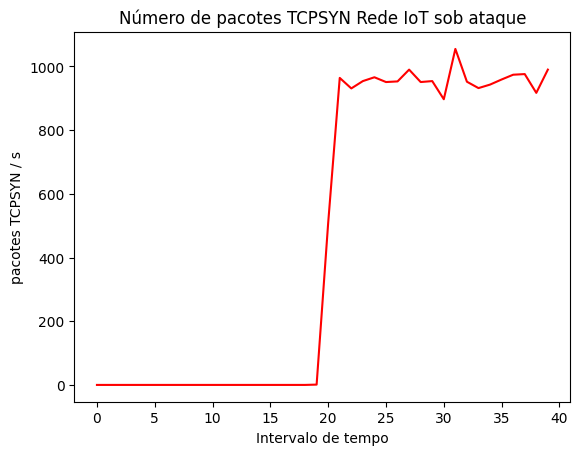

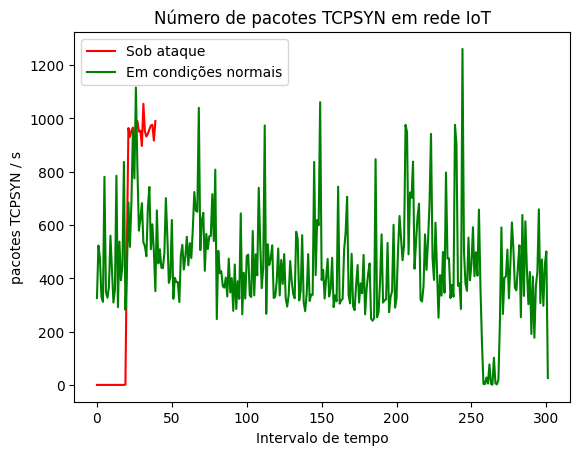

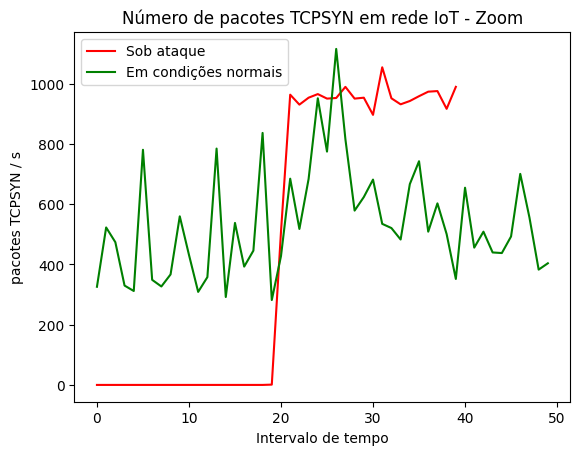

1s
Ataque(s) reconhecido(s): 1
Falso(s) postivo(s): 0
 
500ms
Ataque(s) reconhecido(s): 1
Falso(s) postivo(s): 0
 
100ms
Ataque(s) reconhecido(s): 1
Falso(s) postivo(s): 0


In [211]:
# Carregando dados
dados_normal_100ms=prep_csv("https://raw.githubusercontent.com/hflautert/AnomalyDetection/main/StatsIOTINd/benign-dec_tcpsyn_100ms.csv")
dados_normal_500ms=prep_csv("https://raw.githubusercontent.com/hflautert/AnomalyDetection/main/StatsIOTINd/benign-dec_tcpsyn_500ms.csv")
dados_normal_1s=prep_csv("https://raw.githubusercontent.com/hflautert/AnomalyDetection/main/StatsIOTINd/benign-dec_tcpsyn_1s.csv")

dados_ataque_100ms=prep_csv("https://raw.githubusercontent.com/hflautert/AnomalyDetection/main/StatsIOTINd/dos-synflooding-1-dec_100ms.csv")
dados_ataque_500ms=prep_csv("https://raw.githubusercontent.com/hflautert/AnomalyDetection/main/StatsIOTINd/dos-synflooding-1-dec_500ms.csv")
dados_ataque_1s=prep_csv("https://raw.githubusercontent.com/hflautert/AnomalyDetection/main/StatsIOTINd/dos-synflooding-1-dec_1s.csv")

tipo_dos_pacotes='TCPSYN'

visualiza(dados_normal_1s,'s','g','Rede IoT em condições normais',tipo_dos_pacotes)
visualiza(dados_ataque_1s,'s','r','Rede IoT sob ataque',tipo_dos_pacotes)
visualizamix(dados_ataque_1s,'r',dados_normal_1s,'g','s',tipo_dos_pacotes)

# Vizualização otimizada com zoom na janela de ataque de 1, 10 e 100 pcts/s
v_dados_normal_1s = dados_normal_1s[:50]
v_dados_ataque_1s = dados_ataque_1s[:50]

# Unindo linhas
plt.plot(v_dados_ataque_1s, color = 'r', label = "Sob ataque")
plt.plot(v_dados_normal_1s, color = 'g', label = "Em condições normais")
plt.title('Número de pacotes '+tipo_dos_pacotes+' em rede IoT - Zoom')
plt.xlabel('Intervalo de tempo')
plt.ylabel('pacotes '+tipo_dos_pacotes+' / s')
plt.legend()
plt.show()

print('1s')
ataque,f_positivo=aplica_modelo(dados_normal_1s,dados_ataque_1s,1.10,20,250)
print ("Ataque(s) reconhecido(s):",ataque)
print ("Falso(s) postivo(s):",f_positivo)
print(' \n500ms')
ataque,f_positivo=aplica_modelo(dados_normal_500ms,dados_ataque_500ms,1.10,40,100)
print ("Ataque(s) reconhecido(s):",ataque)
print ("Falso(s) postivo(s):",f_positivo)
print(' \n100ms')
ataque,f_positivo=aplica_modelo(dados_normal_100ms,dados_ataque_100ms,1.10,60,2)
print ("Ataque(s) reconhecido(s):",ataque)
print ("Falso(s) postivo(s):",f_positivo)

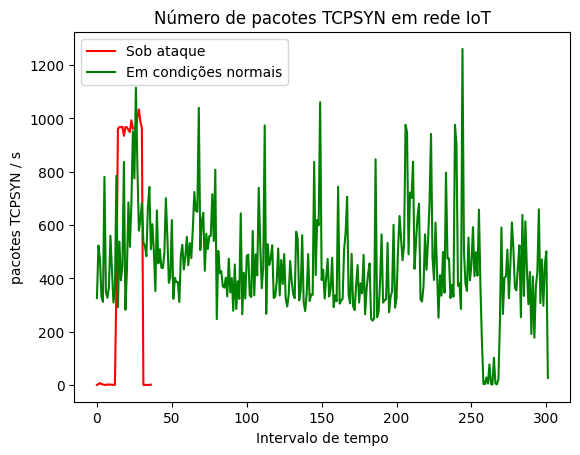

1s
Ataque(s) reconhecido(s): 1
Falso(s) postivo(s): 0
 
500ms
Ataque(s) reconhecido(s): 1
Falso(s) postivo(s): 0
 
100ms
Ataque(s) reconhecido(s): 1
Falso(s) postivo(s): 0


In [210]:
dados_ataque_100ms=prep_csv("https://raw.githubusercontent.com/hflautert/AnomalyDetection/main/StatsIOTINd/dos-synflooding-2-dec_100ms.csv")
dados_ataque_500ms=prep_csv("https://raw.githubusercontent.com/hflautert/AnomalyDetection/main/StatsIOTINd/dos-synflooding-2-dec_500ms.csv")
dados_ataque_1s=prep_csv("https://raw.githubusercontent.com/hflautert/AnomalyDetection/main/StatsIOTINd/dos-synflooding-2-dec_1s.csv")

visualizamix(dados_ataque_1s,'r',dados_normal_1s,'g','s',tipo_dos_pacotes)

print('1s')
ataque,f_positivo=aplica_modelo(dados_normal_1s,dados_ataque_1s,1.10,20,300)
print ("Ataque(s) reconhecido(s):",ataque)
print ("Falso(s) postivo(s):",f_positivo)

print(' \n500ms')
ataque,f_positivo=aplica_modelo(dados_normal_500ms,dados_ataque_500ms,1.10,30,60)
print ("Ataque(s) reconhecido(s):",ataque)
print ("Falso(s) postivo(s):",f_positivo)

print(' \n100ms')
ataque,f_positivo=aplica_modelo(dados_normal_100ms,dados_ataque_100ms,1.10,60,2)
print ("Ataque(s) reconhecido(s):",ataque)
print ("Falso(s) postivo(s):",f_positivo)

In [146]:
dados_ataque_100ms=prep_csv("https://raw.githubusercontent.com/hflautert/AnomalyDetection/main/StatsIOTINd/dos-synflooding-3-dec_100ms.csv")
dados_ataque_500ms=prep_csv("https://raw.githubusercontent.com/hflautert/AnomalyDetection/main/StatsIOTINd/dos-synflooding-3-dec_500ms.csv")
dados_ataque_1s=prep_csv("https://raw.githubusercontent.com/hflautert/AnomalyDetection/main/StatsIOTINd/dos-synflooding-3-dec_1s.csv")

#visualiza(dados_normal_1s,'s','g','Rede IoT em condições normais',tipo_dos_pacotes)
#visualiza(dados_ataque_1s,'s','r','Rede IoT sob ataque',tipo_dos_pacotes)
#visualizamix(dados_ataque_1s,'r',dados_normal_1s,'g','s',tipo_dos_pacotes)

print('1s')
ataque,f_positivo=aplica_modelo(dados_normal_1s,dados_ataque_1s,1.10,15,300)
print ("Ataque(s) reconhecido(s):",ataque)
print ("Falso(s) postivo(s):",f_positivo)

print(' \n500ms')
ataque,f_positivo=aplica_modelo(dados_normal_500ms,dados_ataque_500ms,1.10,20,10)
print ("Ataque(s) reconhecido(s):",ataque)
print ("Falso(s) postivo(s):",f_positivo)

print(' \n100ms')
ataque,f_positivo=aplica_modelo(dados_normal_100ms,dados_ataque_100ms,1.10,60,2)
print ("Ataque(s) reconhecido(s):",ataque)
print ("Falso(s) postivo(s):",f_positivo)

1s
Ataque(s) reconhecido(s): 1
Falso(s) postivo(s): 0
 
500ms
Ataque(s) reconhecido(s): 1
Falso(s) postivo(s): 0
 
100ms
Ataque(s) reconhecido(s): 1
Falso(s) postivo(s): 0


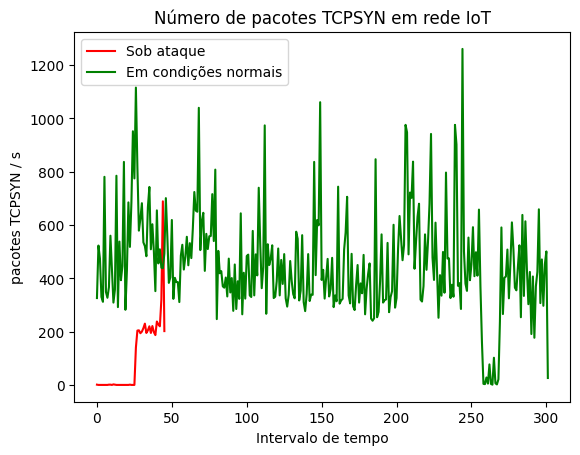

1s
Ataque(s) reconhecido(s): 1
Falso(s) postivo(s): 0
 
500ms
Ataque(s) reconhecido(s): 1
Falso(s) postivo(s): 0
 
100ms
Ataque(s) reconhecido(s): 1
Falso(s) postivo(s): 0


In [208]:
dados_ataque_100ms=prep_csv("https://raw.githubusercontent.com/hflautert/AnomalyDetection/main/StatsIOTINd/dos-synflooding-4-dec_100ms.csv")
dados_ataque_500ms=prep_csv("https://raw.githubusercontent.com/hflautert/AnomalyDetection/main/StatsIOTINd/dos-synflooding-4-dec_500ms.csv")
dados_ataque_1s=prep_csv("https://raw.githubusercontent.com/hflautert/AnomalyDetection/main/StatsIOTINd/dos-synflooding-4-dec_1s.csv")

#visualiza(dados_normal_1s,'s','g','Rede IoT em condições normais',tipo_dos_pacotes)
#visualiza(dados_ataque_1s,'s','r','Rede IoT sob ataque',tipo_dos_pacotes)
visualizamix(dados_ataque_1s,'r',dados_normal_1s,'g','s',tipo_dos_pacotes)

print('1s')
ataque,f_positivo=aplica_modelo(dados_normal_1s,dados_ataque_1s,1.10,30,20)
print ("Ataque(s) reconhecido(s):",ataque)
print ("Falso(s) postivo(s):",f_positivo)

print(' \n500ms')
ataque,f_positivo=aplica_modelo(dados_normal_500ms,dados_ataque_500ms,1.10,20,10)
print ("Ataque(s) reconhecido(s):",ataque)
print ("Falso(s) postivo(s):",f_positivo)

print(' \n100ms')
ataque,f_positivo=aplica_modelo(dados_normal_100ms,dados_ataque_100ms,1.10,60,2)
print ("Ataque(s) reconhecido(s):",ataque)
print ("Falso(s) postivo(s):",f_positivo)

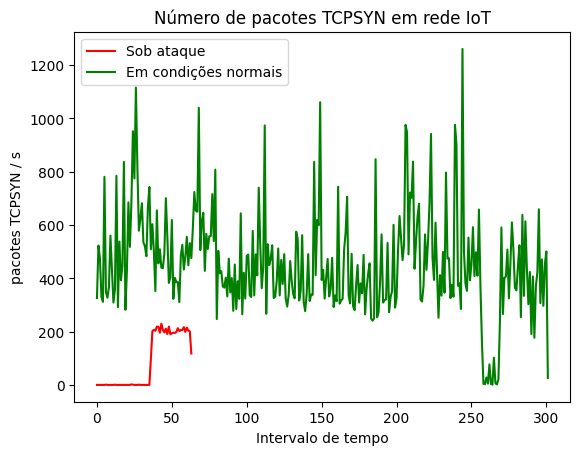

1s
Ataque(s) reconhecido(s): 1
Falso(s) postivo(s): 0
 
500ms
Ataque(s) reconhecido(s): 1
Falso(s) postivo(s): 0
 
100ms
Ataque(s) reconhecido(s): 1
Falso(s) postivo(s): 0


In [209]:
dados_ataque_100ms=prep_csv("https://raw.githubusercontent.com/hflautert/AnomalyDetection/main/StatsIOTINd/dos-synflooding-5-dec_100ms.csv")
dados_ataque_500ms=prep_csv("https://raw.githubusercontent.com/hflautert/AnomalyDetection/main/StatsIOTINd/dos-synflooding-5-dec_500ms.csv")
dados_ataque_1s=prep_csv("https://raw.githubusercontent.com/hflautert/AnomalyDetection/main/StatsIOTINd/dos-synflooding-5-dec_1s.csv")

visualizamix(dados_ataque_1s,'r',dados_normal_1s,'g','s',tipo_dos_pacotes)

print('1s')
ataque,f_positivo=aplica_modelo(dados_normal_1s,dados_ataque_1s,1.10,30,20)
print ("Ataque(s) reconhecido(s):",ataque)
print ("Falso(s) postivo(s):",f_positivo)

print(' \n500ms')
ataque,f_positivo=aplica_modelo(dados_normal_500ms,dados_ataque_500ms,1.10,20,10)
print ("Ataque(s) reconhecido(s):",ataque)
print ("Falso(s) postivo(s):",f_positivo)

print(' \n100ms')
ataque,f_positivo=aplica_modelo(dados_normal_100ms,dados_ataque_100ms,1.10,60,2)
print ("Ataque(s) reconhecido(s):",ataque)
print ("Falso(s) postivo(s):",f_positivo)

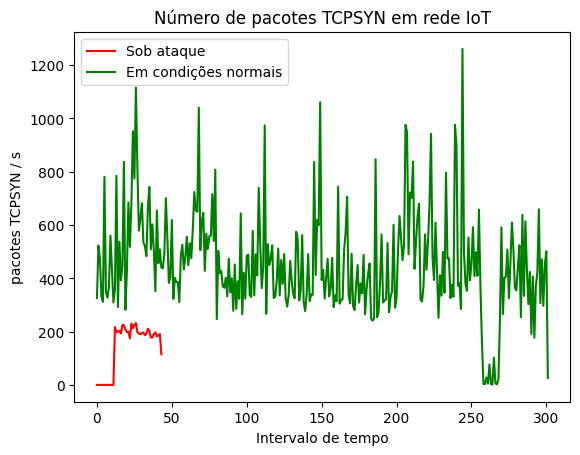

1s
Ataque(s) reconhecido(s): 1
Falso(s) postivo(s): 0
 
500ms
Ataque(s) reconhecido(s): 1
Falso(s) postivo(s): 0
 
100ms
Ataque(s) reconhecido(s): 1
Falso(s) postivo(s): 0


In [207]:
dados_ataque_100ms=prep_csv("https://raw.githubusercontent.com/hflautert/AnomalyDetection/main/StatsIOTINd/dos-synflooding-6-dec_100ms.csv")
dados_ataque_500ms=prep_csv("https://raw.githubusercontent.com/hflautert/AnomalyDetection/main/StatsIOTINd/dos-synflooding-6-dec_500ms.csv")
dados_ataque_1s=prep_csv("https://raw.githubusercontent.com/hflautert/AnomalyDetection/main/StatsIOTINd/dos-synflooding-6-dec_1s.csv")

#visualiza(dados_normal_1s,'s','g','Rede IoT em condições normais',tipo_dos_pacotes)
#visualiza(dados_ataque_1s,'s','r','Rede IoT sob ataque',tipo_dos_pacotes)
visualizamix(dados_ataque_1s,'r',dados_normal_1s,'g','s',tipo_dos_pacotes)

print('1s')
ataque,f_positivo=aplica_modelo(dados_normal_1s,dados_ataque_1s,1.05,30,20)
print ("Ataque(s) reconhecido(s):",ataque)
print ("Falso(s) postivo(s):",f_positivo)

print(' \n500ms')
ataque,f_positivo=aplica_modelo(dados_normal_500ms,dados_ataque_500ms,1.10,20,10)
print ("Ataque(s) reconhecido(s):",ataque)
print ("Falso(s) postivo(s):",f_positivo)

print(' \n100ms')
ataque,f_positivo=aplica_modelo(dados_normal_100ms,dados_ataque_100ms,1.10,60,2)
print ("Ataque(s) reconhecido(s):",ataque)
print ("Falso(s) postivo(s):",f_positivo)